# Neural Network for the Higgs Boson
## Chapter 1: Introduction and Data Preparation

This project analyzes data recorded in 2016 at a center-of-mass energy of $\sqrt{s}=13 \text{ TeV}$ and an integrated luminosity of $10 \text{ fb}^{-1}$. It focuses on searching for $H \rightarrow ZZ \rightarrow llll$ events, so-called "golden channel" since it represents the clearest signature in Higgs boson detection. Then including only datasets with four reconstructed leptons in the final state. The input data is sourced from the 13 TeV ATLAS open data, available at [http://opendata.atlas.cern/release/2020/documentation/index.html](http://opendata.atlas.cern/release/2020/documentation/index.html).

### The Higgs Boson at ATLAS Experiment

The Feynman diagram illustrates the gluon fusion process in a proton-proton collision that leads to the production of a Higgs boson. The Higgs, coupling with massive particles, cannot be directly produced by massless gluons. Instead, it is produced through an intermediate top quark loop. As the heaviest known elementary particle, the top quark strongly couples to the Higgs boson. Due to its large mass, the Higgs boson quickly decays into two Z bosons, which, being massive themselves, decay into a lepton-antilepton pair before reaching the detector.
<div>
<img src='figures/H_ZZ_feynman_diagram.png' width='500'/>
</div>

### Simulation and Event Weights

Since in quantum physics only probabilities of process can be predicted and no the outcomes themselves, is necessary to simulate event frequencies. This involves generating random events based on probability densities, followed by simulating their detection. A distribution for the lepton with the heighest transverse momentum, is obtained. This events are distinguished into various Higgs processes (ggH125_ZZ4lep, VBFH125_ZZ4lep, WH125_ZZ4lep, and ZH125_ZZ4lep) and background processes (llll, Zee, Zmumu, and ttbar_lep).

<img src='figures/event_weights_few_not_applied.png' width='500'/>
</div>



### Data Preparation

### Load the Data

In [129]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import seed
import os

# Import some common functions created for this notebook
import common

# Random state
random_state = 21
_ = np.random.RandomState(random_state)

from sklearn.model_selection import train_test_split 

The goal of this project is to train a deep neural network to separate Higgs boson signal from background events. 
The key signal sample, ggH125_ZZ4lep, represents the process $gg\rightarrow H \rightarrow ZZ$
. The primary background sample, $llll$, originates from Z and ZZ decays. After training, the deep neural network (DNN) model will classify events from these data samples.

Higgs signal samples:
- ggH125_ZZ4lep
- VBFH125_ZZ4lep
- WH125_ZZ4lep
- ZH125_ZZ4lep

Background samples:
- llll
- Zee
- Zmumu
- ttbar_lep

Data samples:
- data_A
- data_B
- data_C
- data_D

In [130]:
# Define the input samples
sample_list_signal = ['ggH125_ZZ4lep', 'VBFH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
sample_list_background = ['llll', 'Zee', 'Zmumu', 'ttbar_lep']

In [131]:
sample_path = 'input'
# Read all the samples
no_selection_data_frames = {}
for sample in sample_list_signal + sample_list_background:
    no_selection_data_frames[sample] = pd.read_csv(os.path.join(sample_path, sample + '.csv'))

### Event Pre-Selection

Before we start with the pre-selection of the input data check the number of events per process.

In [132]:
# Loop over all processes
for sample in sample_list_signal + sample_list_background:
    # Sum over the weights is equal to the number of expected events
    n_events = sum(no_selection_data_frames[sample]['totalWeight'])
    # Number of raw simulation events
    n_events_raw = len(no_selection_data_frames[sample]['totalWeight'])
    print(f'{sample}: {round(n_events, 2)}; {n_events_raw} (raw)')

ggH125_ZZ4lep: 8.87; 164716 (raw)
VBFH125_ZZ4lep: 0.8; 191126 (raw)
WH125_ZZ4lep: 0.35; 15379 (raw)
ZH125_ZZ4lep: 0.0; 14485 (raw)
llll: 280.61; 554279 (raw)
Zee: 170.33; 898 (raw)
Zmumu: 139.34; 684 (raw)
ttbar_lep: 85.66; 1031 (raw)


Although the final selection of the data is to be performed on the basis of a DNN, a rough pre-selection of the data is still useful.
For this purpose, selection criteria are defined, which return either true or false based on the event kinematics and thus decide whether the respective event is kept or discarded.
Suitable criteria for this analysis are very basic selections that must be clearly fulfilled by $H \rightarrow ZZ \rightarrow llll$ processes.
From the feynman diagram of the Higgs decay two very basic criteria can be derived.

1. **Lepton Charge**:
    - Since the Higgs boson is electrically neutral, the sum of the charges of all decay products must also be neutral.

2. **Lepton Type**:
    - Z bosons decay into lepton pairs of the same type, making $Z \rightarrow ee$ and $Z \rightarrow \mu\mu $ possible, but not $Z \rightarrow e\mu$. Due to their high mass, $\tau$ leptons decay before reaching the detector and are excluded from this analysis. Therefore, only consider Particle Data Group IDs: PDG-ID $(e)=11$ for electrons and PDG-ID $(\mu)=13$ for muons.

It's important to remember that leptons are ranked by their transverse momentum, which complicates determining which leptons originated from the same Z boson.

In [133]:
# Create a copy of the original data frame to investigate later
data_frames = no_selection_data_frames.copy()

# Apply the chosen selection criteria
for sample in sample_list_signal + sample_list_background:
    # Selection on lepton type
    type_selection = np.vectorize(common.selection_lepton_type)(
        data_frames[sample].lep1_pdgId,
        data_frames[sample].lep2_pdgId,
        data_frames[sample].lep3_pdgId,
        data_frames[sample].lep4_pdgId)
    data_frames[sample] = data_frames[sample][type_selection]

    # Selection on lepton charge
    charge_selection = np.vectorize(common.selection_lepton_charge)(
        data_frames[sample].lep1_charge,
        data_frames[sample].lep2_charge,
        data_frames[sample].lep3_charge,
        data_frames[sample].lep4_charge)
    data_frames[sample] = data_frames[sample][charge_selection]

After applying the selection criteria outlined above, we can now analyze the impact of these cuts by comparing the distributions before and after the application of the selection rules.

In [134]:
# Loop over all processes
for sample in sample_list_signal + sample_list_background:
    # Sum over the weights is equal to the number of expected events
    n_events = sum(data_frames[sample]['totalWeight'])
    # Number of raw simulation events
    n_events_raw = len(data_frames[sample]['totalWeight'])
    print(f'{sample}: {round(n_events, 2)}; {n_events_raw} (raw)')

ggH125_ZZ4lep: 8.7; 161451 (raw)
VBFH125_ZZ4lep: 0.78; 186870 (raw)
WH125_ZZ4lep: 0.22; 9772 (raw)
ZH125_ZZ4lep: 0.0; 11947 (raw)
llll: 266.55; 523957 (raw)
Zee: 43.42; 243 (raw)
Zmumu: 52.33; 257 (raw)
ttbar_lep: 28.31; 334 (raw)


### Data Investigation

Before selecting which variables to use for training, the input samples are organized into two sets: one comprising signal events and the other comprising background events. This allows for a detailed examination of how both signal and background behaviors manifest across various variables.

In [135]:
# Merge the signal and background data frames
data_frame_signal = common.merge_data_frames(sample_list_signal, data_frames)
data_frame_background = common.merge_data_frames(sample_list_background, data_frames)

Before feeding the data into the neural network, it's beneficial to identify which variables are most discriminative. This step involves analyzing the distribution of variables to determine which ones effectively distinguish between signal and background events.

- The most discriminant variable is the invariant mass of the four-lepton system, $m_{\text{inv}}(l_1, l_2, l_3, l_4)$, which typically peaks at the Higgs boson mass of 125 GeV.
- The angular variables $\phi$ are generally not sensitive to any specific process due to the rotational symmetry of the detector.

Below is an example showing the distribution of the transverse momentum of the leading lepton:

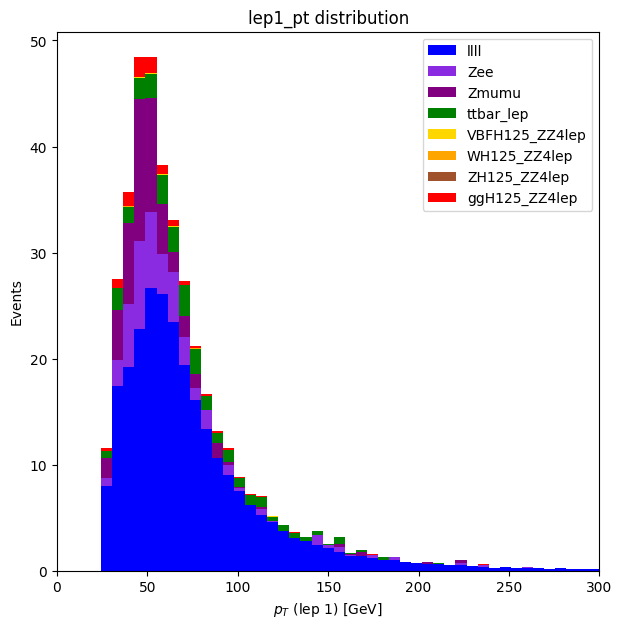

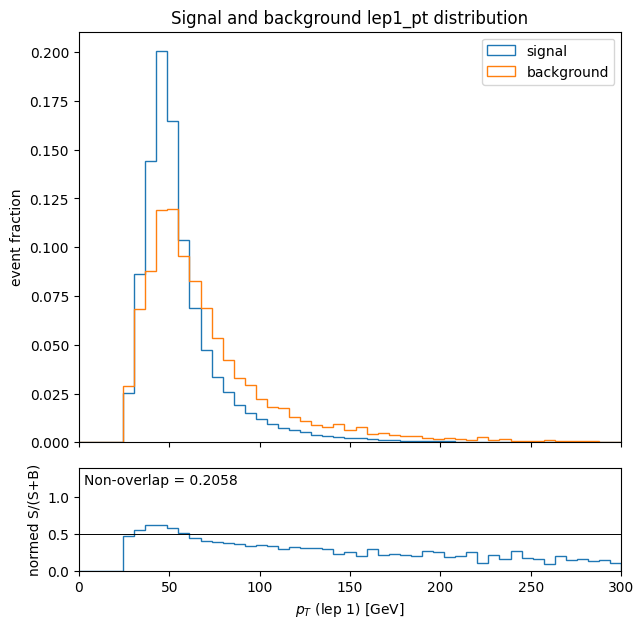

In [136]:
# leading lepton pt
var_lep1_pt = {'variable': 'lep1_pt',
               'binning': np.linspace(0, 300, 50),
               'xlabel': '$p_T$ (lep 1) [GeV]'}

common.plot_hist(var_lep1_pt, data_frames)
common.plot_normed_signal_vs_background(var_lep1_pt, data_frame_signal, data_frame_background)
plt.show()

Before the classfication, purity in signal events for given data can be displayed


In [137]:
signal_event_number = sum(data_frame_signal.totalWeight)
background_event_number = sum(data_frame_background.totalWeight)
signal_background_ratio = signal_event_number/background_event_number
print(f'There are {round(signal_event_number, 2)} signal ({len(data_frame_signal)} raw MC events) and {round(background_event_number, 2)} backgound events ({len(data_frame_background)} raw MC events)\nThis gives a purity of {round(signal_background_ratio*100, 2)}%')

There are 9.7 signal (370040 raw MC events) and 390.61 backgound events (524791 raw MC events)
This gives a purity of 2.48%


As observed, the quantity of simulated raw events far exceeds the weighted number of expected events. Consequently, the contribution of each simulated event to the final prediction is determined by its respective event weight.

To analyze the impact of these weights, we can print out the distribution of weights for both signal and background events

In [138]:
for sample in sample_list_signal + sample_list_background:
    print(f'{sample}:')
    n_events = sum(data_frames[sample]['totalWeight'])
    n_events_raw = len(data_frames[sample]['totalWeight'])
    n_events_neg = sum(data_frames[sample]['totalWeight'] * (data_frames[sample]['totalWeight'] < 0))
    n_events_neg_raw = sum(list(data_frames[sample]['totalWeight'] < 0))
    min_weight = data_frames[sample]['totalWeight'].min()
    med_weight = data_frames[sample]['totalWeight'].median()
    max_weight = data_frames[sample]['totalWeight'].max()
    print(f'  Raw events:      {n_events_raw}')
    print(f'  Prediction:      {round(n_events, 2)}')
    print(f'  Neg. raw events: {round(100 * n_events_neg_raw / n_events_raw, 2)}%')
    print(f'  Neg. events:     {abs(round(100 * n_events_neg / n_events, 2))}%')
    print(f'  Minimal weight:  {min_weight}')
    print(f'  Median weight:   {med_weight}')
    print(f'  Maximal weight:  {max_weight}')
    print()

ggH125_ZZ4lep:
  Raw events:      161451
  Prediction:      8.7
  Neg. raw events: 0.21%
  Neg. events:     0.22%
  Minimal weight:  -0.0001097871068996
  Median weight:   6.048775651863909e-05
  Maximal weight:  0.0002235023285485

VBFH125_ZZ4lep:
  Raw events:      186870
  Prediction:      0.78
  Neg. raw events: 0.18%
  Neg. events:     0.19%
  Minimal weight:  -8.226283411076771e-06
  Median weight:   4.693477814100141e-06
  Maximal weight:  1.707267083872427e-05

WH125_ZZ4lep:
  Raw events:      9772
  Prediction:      0.22
  Neg. raw events: 0.0%
  Neg. events:     0.0%
  Minimal weight:  0.0
  Median weight:   2.4991409279835305e-05
  Maximal weight:  8.08094179970647e-05

ZH125_ZZ4lep:
  Raw events:      11947
  Prediction:      0.0
  Neg. raw events: 0.0%
  Neg. events:     0.0%
  Minimal weight:  0.0
  Median weight:   1.420687246809822e-07
  Maximal weight:  4.585081735318556e-07

llll:
  Raw events:      523957
  Prediction:      266.55
  Neg. raw events: 10.36%
  Neg. eve


As expected, the different processes were simulated with different accuracy. 
Furthermore, we can see the event weights even go into the negative range. Negative weighted events are produced to compensate overshooting predictions in certain kinematic areas.

## Chapter 2: Create and Train a Neural Network

Now we are going to train the neural network. We begin with the data preparation step.

### Data Preaparation
### Get Test and Training Data

During the training phase, the neural network's parameters are adjusted according to the training data. To assess how the model performs on entirely new data, we will train it on a subset of the available data. Specifically, 60% of the data will be designated for training, with the remaining 40% reserved for testing, through the `split_data_frames` function Additionally, this function adjusts the event weights within the dataframes, ensuring that even if due to the split, both training and validation data, will have less simulated events than the original dataset, they maintain the same total prediction. 

In [139]:
train_data_frames, test_data_frames = common.split_data_frames(data_frames, 0.6)

In [140]:
# Print the number of simulated events and the total prediction for the full, train, and test datasets
for name in data_frames.keys():
    print(name)
    full_set = data_frames[name]
    train_set = train_data_frames[name]
    test_set = test_data_frames[name]
    full_set_pred = full_set['totalWeight'].sum()
    train_set_pred = train_set['totalWeight'].sum()
    test_set_pred = test_set['totalWeight'].sum()
    
    
    print(f'Number of simulated events:\tfull:{len(full_set)}\ttrain:{len(train_set)}\ttest:{len(test_set)}')
    print(f'Number of predicted events:\tfull:{round(full_set_pred, 3)}\ttrain:{round(train_set_pred, 3)}\ttest:{round(test_set_pred, 3)}')

ggH125_ZZ4lep
Number of simulated events:	full:161451	train:96334	test:65117
Number of predicted events:	full:8.695	train:8.695	test:8.695
VBFH125_ZZ4lep
Number of simulated events:	full:186870	train:112448	test:74422
Number of predicted events:	full:0.78	train:0.78	test:0.78
WH125_ZZ4lep
Number of simulated events:	full:9772	train:5806	test:3966
Number of predicted events:	full:0.219	train:0.219	test:0.219
ZH125_ZZ4lep
Number of simulated events:	full:11947	train:7126	test:4821
Number of predicted events:	full:0.002	train:0.002	test:0.002
llll
Number of simulated events:	full:523957	train:315018	test:208939
Number of predicted events:	full:266.547	train:266.547	test:266.547
Zee
Number of simulated events:	full:243	train:147	test:96
Number of predicted events:	full:43.418	train:43.418	test:43.418
Zmumu
Number of simulated events:	full:257	train:143	test:114
Number of predicted events:	full:52.332	train:52.332	test:52.332
ttbar_lep
Number of simulated events:	full:334	train:194	test:140

### Creation of the Neural Network

First we train  on the transverse momentum of the leptons, using a simplified approach and without incluing all the possible processes to speed up the training.

In [141]:
# The training input variables
training_variables = ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']

Extraction of the training variables, the event weights, and the classification of the events. The classification is 0 for background processes and 1 for Higgs events. 

In [142]:
values, weights, classification = common.get_dnn_input(train_data_frames, training_variables, sample_list_signal, sample_list_background)

In [143]:
# Show values of 6 random events
random_idx = [1841, 11852, 15297, 263217, 278357, 331697]
# Training variables
print('Training values:')
print(values[random_idx])
# Event weights
print('Event weights:')
print(weights[random_idx])
# Classification
print('Classification:')
print(classification[random_idx])

Training values:
[[49.80159766 36.19812891 17.6505918  11.6744043 ]
 [47.93708594 40.99171875 21.74950195 10.50760937]
 [78.36921875 41.17754297 34.85229688 20.98207227]
 [59.78630859 37.06260938 34.4363125  18.11307617]
 [53.54299219 43.27517969 34.70514844 23.85172656]
 [70.8075     52.36716016 49.98601563 41.33029688]]
Event weights:
[1.24125080e-04 1.07796248e-04 6.62917602e-05 2.19657123e-04
 1.46148866e-03 2.17560136e-03]
Classification:
[1. 1. 1. 0. 0. 0.]


The Python Library 'Tensorflow' is utilized to develop and train neural networks. First, import the necessary module and transform the training values and classifications into a tensorflow dataset.

In [144]:
# Import the tensorflow module to create a neural network
import tensorflow as tf
from tensorflow.data import Dataset

In [145]:
# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((values, classification))
train_data = train_data.shuffle(len(values), seed=random_state)
# Set the batch size
train_data = train_data.batch(128)

We are going to build a neural network made by several layers, following the model shown below:
<div>
<img src='figures/simple_model.png' width='900'/>
</div>

- To improve the convergence of the training process, the input variables are scaled and shifted to have the mean of 0 and the standard deviation of 1.
- Use two dense layers with 60 neurons each. The neurons are activated with the relu function.
- To classify background and signal the last layer consists of a single neuron described by a sigmoid function to produce an activation  between 0 and 1.

Create a normalization layer and adapt it to the training values:

In [146]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization(name='Input_normalization')
normalization_layer.adapt(values)

Create a list of model layers and build the model:

In [147]:
# Create model
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu', name='Hidden_layer_1'),
    tf.keras.layers.Dense(60, activation='relu', name='Hidden_layer_2'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='Output_layer'),
]
model = tf.keras.models.Sequential(model_layers, name='simple_model')

Before starting the training, we can have a look at the shape and the number of trainable parameters

In [148]:
# Display the model's architecture
model.summary()

Model: "simple_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_normalization             │ ?                      │             9 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer_1 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer_2 (Dense)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (40.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9 (40.00 B)

### Training the Neural Network

For training, a loss function is used to evaluate the divergence between the model's predictions and the true values. A high loss indicates poor agreement, while a low loss indicates good agreement. Since we are dealing with a binary classification problem (separating signal from background), we use binary cross-entropy as the loss function. This calculates the loss by evaluating the difference between true labels and predicted probabilities, encouraging predictions to align closely with the actual categories. The goal during training is to minimize this loss, effectively refining the model to approximate the true distribution more accurately.

In [149]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

The Adam optimizer is used to adjust theparameters in our neural network, aiming to reduce errors. It updates small groups of data at a time, called batches. As it processes each batch, it tweaks the network's settings slightly to improve performance. After it goes through all the batches once, that completes an "epoch." By repeating this process over several epochs, the Adam optimizer helps the network learn and gradually get better at its task.

In [150]:
# Optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9)

Configure the model for the training

In [151]:
# Compilation
model.compile(optimizer=adam_optimizer, loss=loss_fn, metrics=['binary_accuracy'])

Lets train the model for 10 epochs and store the training history in a variable.

In [152]:
history = model.fit(train_data, epochs=10)

Epoch 1/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - binary_accuracy: 0.7422 - loss: 0.5291
Epoch 2/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - binary_accuracy: 0.7818 - loss: 0.4721
Epoch 3/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - binary_accuracy: 0.7829 - loss: 0.4701
Epoch 4/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - binary_accuracy: 0.7834 - loss: 0.4679
Epoch 5/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - binary_accuracy: 0.7840 - loss: 0.4666
Epoch 6/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - binary_accuracy: 0.7843 - loss: 0.4670
Epoch 7/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - binary_accuracy: 0.7847 - loss: 0.4662
Epoch 8/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - binary_accuracy: 0.7854 - loss: 0.4657
Epoch 9/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - binary_accuracy: 0.7852 - loss: 0.4663
Epoch 10/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - binary_accuracy: 0.7839 - loss: 0.4670


Dispaly the training progress of the model.

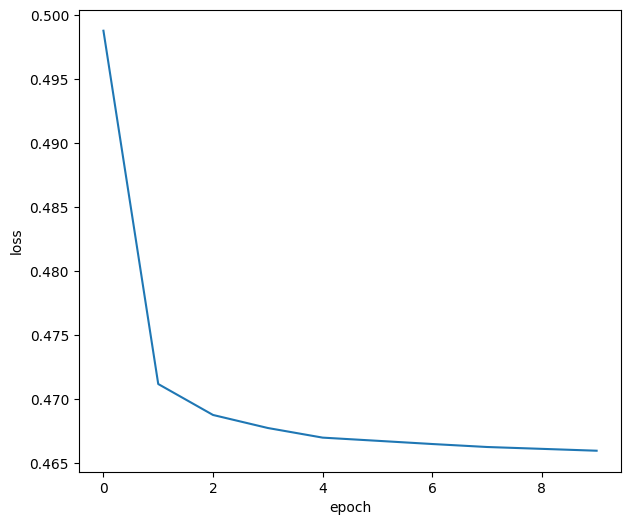

In [153]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(history.history['loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
_ = plt.show()

### Save and Load the Neural Network

Save the model

In [154]:
model.save('./models/chapter2_model.keras')

Load the model and plot its summary

In [155]:
saved_model = tf.keras.models.load_model('models/chapter2_model.keras')

saved_model.summary()

Model: "simple_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_normalization             │ (None, 4)              │             9 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer_1 (Dense)          │ (None, 60)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer_2 (Dense)          │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,074 (47.17 KB)

 Trainable params: 4,021 (15.71 KB)

 Non-trainable params: 9 (40.00 B)

 Optimizer params: 8,044 (31.43 KB)

## Chapter 3: Application of the Neural Network

### Application on Train Data

Once the model is trained,  the training data can be extracted

In [156]:
# The training input variables
training_variables = ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']

In [157]:
# Extract the values and classification
values, _, classification = common.get_dnn_input(train_data_frames, training_variables, sample_list_signal, sample_list_background)

Compare the true classification of some random events and the prediction the model gives for these events.

In [158]:
# Choose some random events
random_idx = [1841, 11852, 15297, 263217, 278357, 331697]
print('Classification:')
print(classification[random_idx])
print('Prediction')
print(model.predict(values[random_idx]))

Classification:
[1. 1. 1. 0. 0. 0.]
Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
[[0.89274323]
 [0.8671495 ]
 [0.2613996 ]
 [0.32438424]
 [0.13934825]
 [0.03988862]]


Get the prediction for all events and use <code>common.plot_dnn_output(...)</code> to plot the result.
</font>

In [159]:
# Apply the model for all values
prediction = model.predict(values)

16788/16788 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step


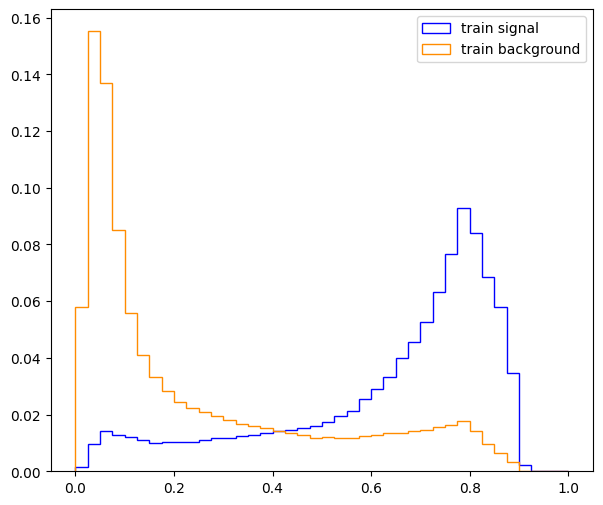

In [160]:
# Plot the model output
common.plot_dnn_output(prediction, classification)
_ = plt.show()

### Application on Test Data

We will now apply the model to all samples and incorporate the classification results into the data frame. In this way, the predictions can be visualized alongside other kinematic variables.

In [161]:
# Apply the model
data_frames_apply_dnn = common.apply_dnn_model(model, test_data_frames, training_variables, sample_list_signal + sample_list_background)

Applying Model for ggH125_ZZ4lep
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Applying Model for VBFH125_ZZ4lep
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Applying Model for WH125_ZZ4lep
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Applying Model for ZH125_ZZ4lep
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Applying Model for llll
6530/6530 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
Applying Model for Zee
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Applying Model for Zmumu
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Applying Model for ttbar_lep
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Once the classification is added to the data frames we can plot it like other variables.

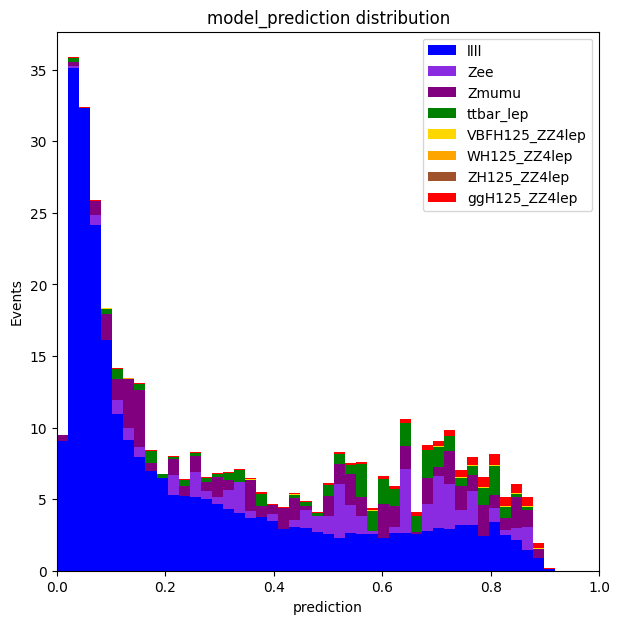

In [162]:
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0, 1, 50),
                    'xlabel': 'prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)
plt.show()

The final classification provided by the neural network on unseen data has not yet met the desired standards. In the upcoming sections, we will refine this classification to develop a more consistent model.

## Chapter 4: Validation Data and Early Stopping

In this section, we will test two strategies to improve the performance of the DNN. 
The first one consists of creating a validation dataset to monitor the training progress, while the second one consists of implementing the so-called early stopping, to automatically stop the training at the optimal point.

As before, we use 2/3 of the training data for the training itself and 1/3 to validate the model performance.

In [163]:
# Split into train and validation data
train_values, val_values, train_classification, val_classification = train_test_split(values, classification, test_size=1/3, random_state=random_state)

### Create the Neural Network


Now, we'll expand our Neural Network implementation to include not just the training dataset but also a validation set. We'll follow these steps:

- Create tensorflow datasets for both training and validation data, with 128 events per batch
- Recreate and adapt the normalization layer to accommodate the new data.
- Recreate the tensorflow model, with two hidden layers each containing 60 nodes.
</font>

In [164]:
# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

In [165]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
model = tf.keras.models.Sequential(model_layers)

### Train the Neural Network

Lets choose the same loss function and optimizer and compile the model.

In [166]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9)

In [167]:
# Compile model
model.compile(optimizer=adam_optimizer, loss=loss_fn, metrics=['binary_accuracy'])

Determining the right amount of training is crucial for optimal neural network performance. Insufficient training leads to undertraining, where the model fails to learn the underlying patterns adequately , resulting in poor performance. Conversely, excessive training can lead to overtraining, where the model memorizes the training data, performing well on it but poorly on unseen data.

To ensure the model performs well on new data, it's tested on validation data after each training epoch. If the model's performance on the validation data stops improving, it indicates that further training might not yield better results. 

Early stopping monitors a specific metric, such as validation loss (`val_loss`), and stops the training if there's no improvement over a set number of epochs (`patience=5`).Given that the model's performance might decline over these 5 epochs, we use `restore_best_weights=True` to revert the model to its best-performing state. To ensure the training continues until no further improvements are seen, the total number of epochs can be set to a high value, effectively allowing the training to stop only when improvements cease.

In [168]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [169]:
# Train model with early stopping for the validation data performance
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=100)

Epoch 1/100
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - binary_accuracy: 0.7398 - loss: 0.5402 - val_binary_accuracy: 0.7803 - val_loss: 0.4751
Epoch 2/100
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.7805 - loss: 0.4759 - val_binary_accuracy: 0.7828 - val_loss: 0.4693
Epoch 3/100
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.7828 - loss: 0.4714 - val_binary_accuracy: 0.7837 - val_loss: 0.4676
Epoch 4/100
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.7834 - loss: 0.4682 - val_binary_accuracy: 0.7844 - val_loss: 0.4670
Epoch 5/100
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.7843 - loss: 0.4675 - val_binary_accuracy: 0.7849 - val_loss: 0.4660
Epoch 6/100
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.7852 - loss: 0.4659 - val_binary_accuracy: 0.7844 - val_loss: 0.4667
Epoch 7/100
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.7838 - loss: 0.4678 - val_binary_accuracy: 0.78


Plot the training loss and validation loss. 
</font>

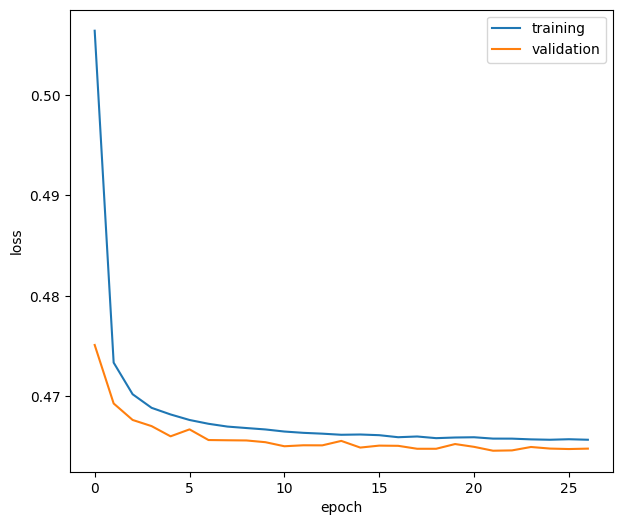

In [170]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
# Training loss
ax.plot(history.history['loss'], label='training')
# Validation loss
ax.plot(history.history['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

### Apply and Evaluate the Neural Network on Training and Validation Data

The model itself has already an implemented evaluation function that we can use to check its performance.

In [171]:
# Evaluate model on training
model_train_evaluation = model.evaluate(train_data)

print(f'train loss = {round(model_train_evaluation[0], 5)}\ttrain accuracy = {round(model_train_evaluation[1], 5)}')

2798/2798 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - binary_accuracy: 0.7864 - loss: 0.4649
train loss = 0.46531	train accuracy = 0.78549



Evaluate the model on validation data and compare the results to the validation on training data.
</font>

In [172]:
# Evaluate model on validation data
model_val_evaluation = model.evaluate(val_data)

print(f'val loss = {round(model_val_evaluation[0], 5)}\tval accuracy = {round(model_val_evaluation[1], 5)}')

1399/1399 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - binary_accuracy: 0.7860 - loss: 0.4647
val loss = 0.46459	val accuracy = 0.78567


Now lets apply the model on the train and validation data and plot the classification.

In [173]:
# Apply the model for training and validation values
train_prediction = model.predict(train_values)
val_prediction = model.predict(val_values)

11192/11192 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
5596/5596 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


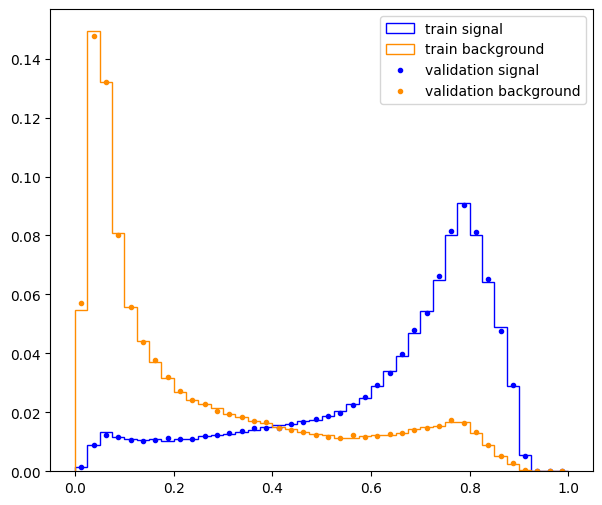

In [174]:
# Plot the model output
common.plot_dnn_output(train_prediction, train_classification, val_prediction, val_classification)
_ = plt.show()

The classification results for both the training and validation data are very consistent. Note that a significant discrepancy between these results would indicate overtraining.

### Prediction on Test Data

In [175]:
# Apply the model
data_frames_apply_dnn = common.apply_dnn_model(model, data_frames, training_variables, sample_list_signal + sample_list_background)

Applying Model for ggH125_ZZ4lep
5046/5046 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Applying Model for VBFH125_ZZ4lep
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Applying Model for WH125_ZZ4lep
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Applying Model for ZH125_ZZ4lep
374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Applying Model for llll
16374/16374 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
Applying Model for Zee
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Applying Model for Zmumu
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Applying Model for ttbar_lep
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


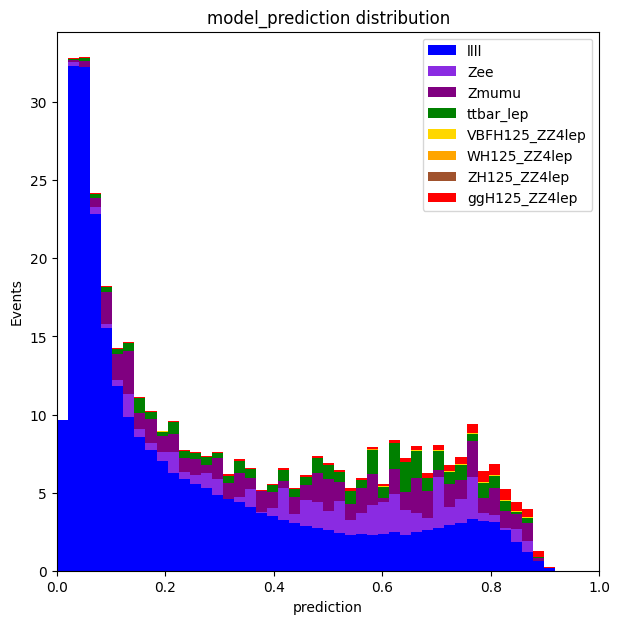

In [176]:
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0, 1, 50),
                    'xlabel': 'prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)
plt.show()

### Save and Load the Model
The model is saved for a later comparison

In [177]:
model.save('./models/chapter4_model.keras')

## Chapter 5: Training with Event Weights

We will now incorporate event weights into the training process. When applied correctly, these weights can significantly enhance the training outcomes.

The simulated events are multiplied by weight factors for the final prediction of measured data. Thus, events with large weights are more important for the prediction than events with small weights. In order to take this into account for the training, the event weights $w_i$ can be included in the calculation of the loss:<br>
$H = -\frac{1}{N} \sum_i^N w_i (y_i^{true} log(y_i^{predict}) + (1 - y_i^{true}) log(1 - y_i^{predict}))$

Extract also the weights for the tarining and validation data

In [178]:
# Extract the values, weights, and classification of the data
values, weights, classification = common.get_dnn_input(train_data_frames, training_variables, sample_list_signal, sample_list_background)

To split the weights into training and validation sets, the `train_test_split()` function can be used. It's important to apply the same split to the weights as to the values and classification so that weights are associated with the corresponding events. This can be achieved by using the same random state for the split of values and classification and the split of the weights.


In [179]:
# Split into train and validation data
train_values, val_values, train_classification, val_classification = train_test_split(values, classification, test_size=1/3, random_state=random_state)
train_weights, val_weights = train_test_split(weights, classification, test_size=1/3, random_state=random_state)[:2]

### Create the Neural Network

Using training weights is straightforward, as they can be directly included in the tensorflow datasets.

In [180]:
# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

same strategy as before is used:
- Recreate and adapt the normalization layer
- Recreate the tensorflow model with 2 hidden layers and 60 nodes per layer
</font>

In [181]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
model = tf.keras.models.Sequential(model_layers)

### Train the Neural Network

In [182]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9)

To monitor the training with weights one should use the weighted metric. This metric is calculated with the provided weights of the training dataset.

In [183]:
# Compile model now with the weighted metric
model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])


Fit the model with validation data and early stopping.
</font>

In [184]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [185]:
# Train model
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - binary_accuracy: 0.9499 - loss: 1.6838e-04 - val_binary_accuracy: 0.9757 - val_loss: 7.6278e-05
Epoch 2/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.9753 - loss: 7.4370e-05 - val_binary_accuracy: 0.9757 - val_loss: 7.4862e-05
Epoch 3/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.9765 - loss: 7.4299e-05 - val_binary_accuracy: 0.9757 - val_loss: 7.3483e-05
Epoch 4/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.9755 - loss: 7.1910e-05 - val_binary_accuracy: 0.9757 - val_loss: 7.2691e-05
Epoch 5/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.9757 - loss: 7.1970e-05 - val_binary_accuracy: 0.9757 - val_loss: 7.1820e-05
Epoch 6/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.9761 - loss: 7.1248e-05 - val_binary_accuracy: 0.9757 - val_loss: 7.1883e-05
Epoch 7/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accu

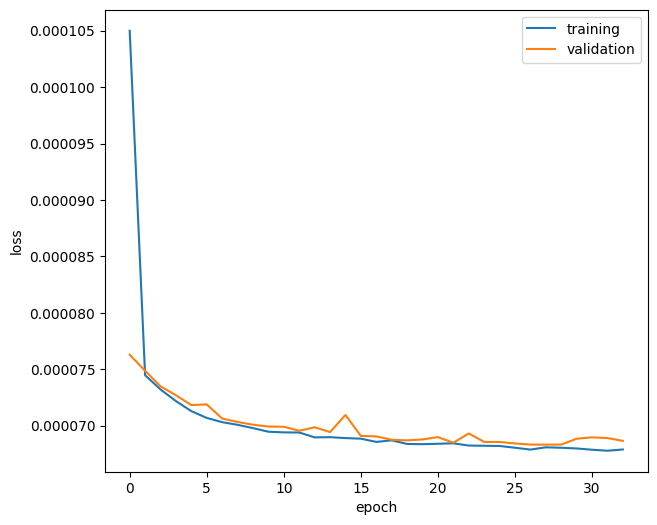

In [186]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

### Apply and Evaluate the Neural Network on Training and Validation Data


- Apply the model on the training and validation data and plot the classification
- Evaluate the loss and accuracy for the training and validation data
</font>

11192/11192 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
5596/5596 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


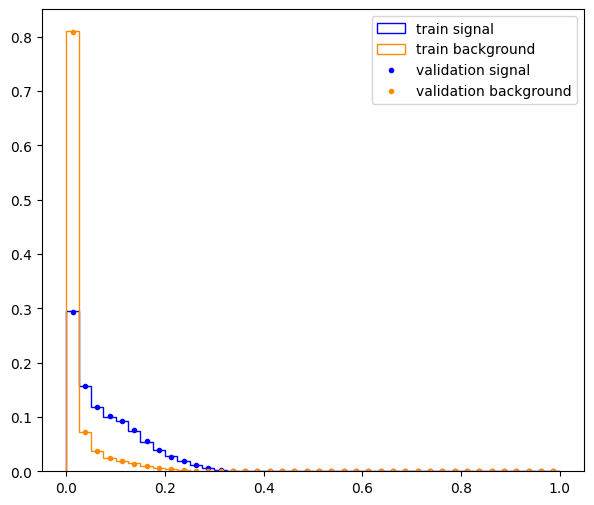

In [187]:
# Apply the model for training and validation values
train_prediction = model.predict(train_values)
val_prediction = model.predict(val_values)

# Plot the model output
common.plot_dnn_output(train_prediction, train_classification, val_prediction, val_classification)
_ = plt.show()

In [188]:
# Evaluate the model on training and validation data
model_train_evaluation = model.evaluate(train_data)
model_val_evaluation = model.evaluate(val_data)

print(f'train loss = {round(model_train_evaluation[0], 5)}\ttrain binary accuracy = {round(model_train_evaluation[1], 5)}')
print(f'val loss = {round(model_val_evaluation[0], 5)}\tval binary accuracy = {round(model_val_evaluation[1], 5)}')

2798/2798 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - binary_accuracy: 0.9756 - loss: 6.6629e-05
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - binary_accuracy: 0.9749 - loss: 6.7274e-05
train loss = 7e-05	train binary accuracy = 0.97583
val loss = 7e-05	val binary accuracy = 0.97568


In [189]:
# Check the event weights
mean_signal_weight = weights[classification > 0.5].mean()
mean_background_weight = weights[classification < 0.5].mean()
print(f'The mean weight for signal events is {np.round(mean_signal_weight, 7)} and for background events {np.round(mean_background_weight, 7)}')

The mean weight for signal events is 4.37e-05 and for background events 0.0012381


### Reweight the Event Weights

Introducing event weights has resulted in the background dominating the training, as the weighted loss is quite low if all data is classified close to background:

$$H = -\frac{1}{N} \sum_i^N w_i (y_i^{true} \log(y_i^{predict}) + (1 - y_i^{true}) \log(1 - y_i^{predict}))$$

To address this, we need to adjust the weights so that signal and background events have an equal impact on training.


We therefore need a function that reweights the given weights:<br>
1. Take the absolute value of the weight to not run into problems with negative weights
2. Split the weights into signal and background weights (by setting the other weights in the array to zero)
3. Scale the signal weights to have the total sum as the background weights
4. Merge the background and scaled signal weights
5. Scale all weights to have a mean weight of 1
</font><br>

In [190]:
def reweight_weights(weights, classification):
    # Take the absolute value of the weight
    weights_abs = np.abs(weights)
    # Split in signal and background weights
    weights_signal = weights_abs*classification
    weights_background = weights_abs*(1 - classification)
    # Scale the signal events
    weights_signal_scaled = weights_signal * sum(weights_background) / sum(weights_signal)
    # Merge the signal and background events
    weights_reweighted = weights_background + weights_signal_scaled
    # Normalize mean weight to one
    weights_reweighted /= weights_reweighted.mean()
    return weights_reweighted


Before proceding, we will test the reweighting function. The mean of all weights should be 1 and the sum of signal weights and background weights should be equal.
</font>

In [191]:
weights_reweighted = reweight_weights(weights, classification)
signal_weights_reweighted = weights_reweighted[classification > 0.5]
background_weights_reweighted = weights_reweighted[classification < 0.5]

print(f'Mean weight: {weights_reweighted.mean()}')
print(f'Signal weight sum: {signal_weights_reweighted.sum()}')
print(f'Background weight sum: {background_weights_reweighted.sum()}')

Mean weight: 0.9999999999999996
Signal weight sum: 268608.0000000052
Background weight sum: 268607.9999999948


Having checked that the reweighting function is optimal, it can be saved to be used in next chapters. 

In [192]:
%%writefile functions/reweight_weights.py
import numpy as np

Overwriting functions/reweight_weights.py


In [193]:
from inspect import getsource, getmodulename
%save -a functions/reweight_weights.py getsource(reweight_weights)

The following commands were written to file `functions/reweight_weights.py`:
def reweight_weights(weights, classification):
    # Take the absolute value of the weight
    weights_abs = np.abs(weights)
    # Split in signal and background weights
    weights_signal = weights_abs*classification
    weights_background = weights_abs*(1 - classification)
    # Scale the signal events
    weights_signal_scaled = weights_signal * sum(weights_background) / sum(weights_signal)
    # Merge the signal and background events
    weights_reweighted = weights_background + weights_signal_scaled
    # Normalize mean weight to one
    weights_reweighted /= weights_reweighted.mean()
    return weights_reweighted



### Recreate and Retrain the Neural Network


Now we can create tensorflow datasets with the reweighted event weights for training and validation.
</font>

In [194]:
# Get reweighted weights
train_weights_reweighted = reweight_weights(train_weights, train_classification)
val_weights_reweighted = reweight_weights(val_weights, val_classification)

# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

In [195]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
model = tf.keras.models.Sequential(model_layers)
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9)

In [196]:
# Compile model
model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])
# Train model
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - binary_accuracy: 0.7047 - loss: 0.5878 - val_binary_accuracy: 0.7294 - val_loss: 0.5372
Epoch 2/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.7423 - loss: 0.5197 - val_binary_accuracy: 0.7746 - val_loss: 0.5089
Epoch 3/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - binary_accuracy: 0.7613 - loss: 0.5191 - val_binary_accuracy: 0.7773 - val_loss: 0.4898
Epoch 4/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - binary_accuracy: 0.7781 - loss: 0.4827 - val_binary_accuracy: 0.7741 - val_loss: 0.4853
Epoch 5/1000
2798/2798 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.7821 - loss: 0.4864 - val_binary_accuracy: 0.7790 - val_loss: 0.4781


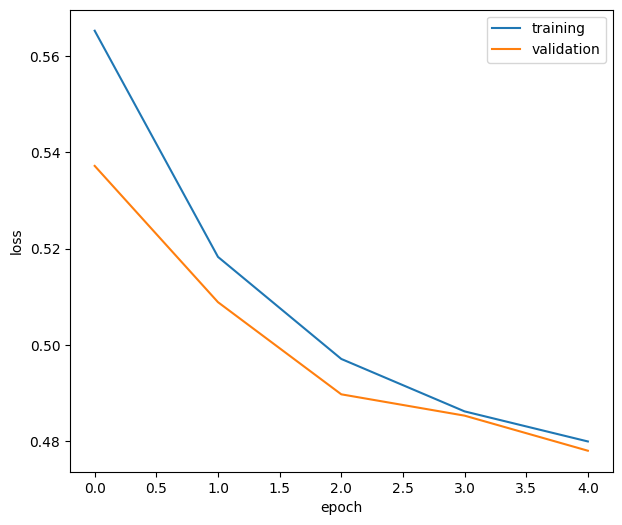

In [197]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

### Apply and Evaluate the Neural Network on Training and Validation Data

11192/11192 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
5596/5596 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


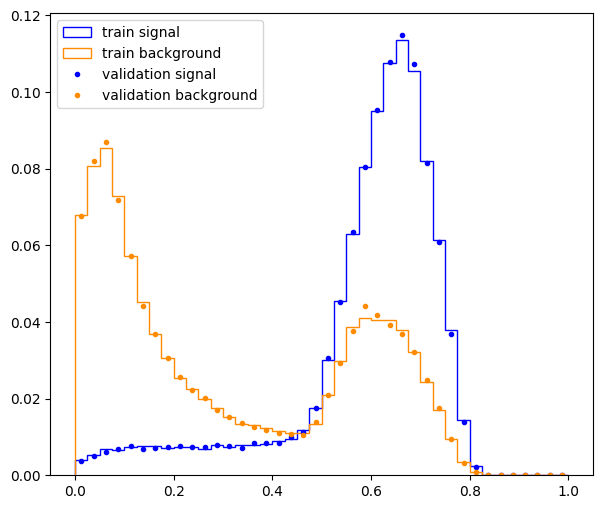

In [198]:
# Apply the model for training and validation values
train_prediction = model.predict(train_values)
val_prediction = model.predict(val_values)
# Plot the model output
common.plot_dnn_output(train_prediction, train_classification, val_prediction, val_classification)
_ = plt.show()

In [199]:
# Evaluate the model on training and validation data
model_train_evaluation = model.evaluate(train_data)
model_val_evaluation = model.evaluate(val_data)

print(f'train loss = {round(model_train_evaluation[0], 5)}\ttrain binary accuracy = {round(model_train_evaluation[1], 5)}')
print(f'val loss = {round(model_val_evaluation[0], 5)}\tval binary accuracy = {round(model_val_evaluation[1], 5)}')

2798/2798 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - binary_accuracy: 0.7236 - loss: 0.5355
1399/1399 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - binary_accuracy: 0.7440 - loss: 0.5255
train loss = 0.53326	train binary accuracy = 0.7262
val loss = 0.53718	val binary accuracy = 0.72944


### Prediction on Test Data

Applying Model for ggH125_ZZ4lep
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Applying Model for VBFH125_ZZ4lep
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Applying Model for WH125_ZZ4lep
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Applying Model for ZH125_ZZ4lep
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Applying Model for llll
6530/6530 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Applying Model for Zee
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Applying Model for Zmumu
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
Applying Model for ttbar_lep
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


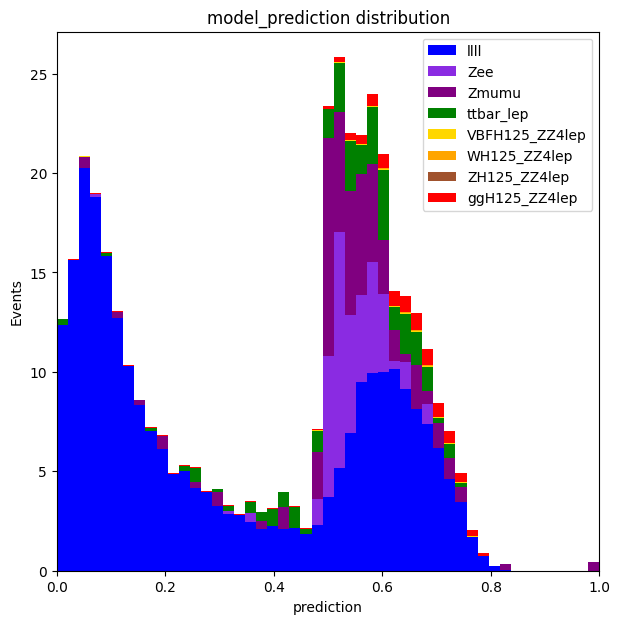

In [200]:
# Apply the model on the test data
data_frames_apply_dnn = common.apply_dnn_model(model, test_data_frames, training_variables, sample_list_signal + sample_list_background)
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0, 1, 50),
                    'xlabel': 'prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)
plt.show()

### Save and Load a Model

In [201]:
model.save('./models/chapter5_model.keras')

## Chapter 6: Cross-Validation


### Cross-Validation

In the training history, fluctuations in the validation loss and a limited-size of the validation dataset can be noticed, making it not completely representative for validation.

To evaluate and compare the performance of models effectively, one common method is k-fold cross-validation. The training data is split several times with non-overlapping validation sets. A model is trained and validated on each of these splits, resulting in multiple independently trained models of the same size and setup, each validated against a different dataset. This allows for the calculation of the average performance across all models.

In [202]:
# Import the kFold module for cross-validation
from sklearn.model_selection import KFold

In [203]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True, random_state=random_state)

kFold is used to train several models in a for loop. In each iteration a new model is created and trained.
This results into three models trained and validated on overlapping training sets and not overlapping validation sets.

In [204]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Store the models and their training history
kfold_history = []
kfold_model = []
# Store the evaluation on training and validation data
kfold_train_eval_loss = []
kfold_train_eval_acc = []
kfold_val_eval_loss = []
kfold_val_eval_acc = []
split_idx = 1
for train_indices, val_indices in kfold.split(values):
    print(f'Use fold {split_idx}')
    split_idx += 1
    # Get train and validation data 
    train_values = values[train_indices]
    train_classification = classification[train_indices]
    train_weights = weights[train_indices]
    val_values = values[val_indices]
    val_classification = classification[val_indices]
    val_weights = weights[val_indices]
    # Get reweighted weights
    train_weights_reweighted = reweight_weights(train_weights, train_classification)
    val_weights_reweighted = reweight_weights(val_weights, val_classification)
    # Get train and validation datasets
    train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
    train_data = train_data.shuffle(len(train_data), seed=random_state)
    train_data = train_data.batch(124)
    val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
    val_data = val_data.shuffle(len(val_data), seed=random_state)
    val_data = val_data.batch(124)

    # Normalization layer
    normalization_layer = tf.keras.layers.Normalization()
    normalization_layer.adapt(train_values)
    # Create a simple NN
    model_layers = [
        normalization_layer,
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ]
    model = tf.keras.models.Sequential(model_layers)
    # Optimizer
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9)
    # Compile model
    model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])

    # Train model
    history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

    # Append to list
    kfold_history.append(history)
    kfold_model.append(model)

    # Evaluate model on training and validation data
    model_train_evaluation = model.evaluate(train_data)
    model_val_evaluation = model.evaluate(val_data)
    kfold_train_eval_loss.append(model_train_evaluation[0])
    kfold_train_eval_acc.append(model_train_evaluation[1])
    kfold_val_eval_loss.append(model_val_evaluation[0])
    kfold_val_eval_acc.append(model_val_evaluation[1])

Use fold 1
Epoch 1/1000
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - binary_accuracy: 0.7142 - loss: 0.5767 - val_binary_accuracy: 0.7388 - val_loss: 0.5351
Epoch 2/1000
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.7452 - loss: 0.5163 - val_binary_accuracy: 0.7728 - val_loss: 0.5069
Epoch 3/1000
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.7729 - loss: 0.5075 - val_binary_accuracy: 0.7701 - val_loss: 0.4898
Epoch 4/1000
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - binary_accuracy: 0.7686 - loss: 0.5013 - val_binary_accuracy: 0.7819 - val_loss: 0.4817
Epoch 5/1000
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - binary_accuracy: 0.7764 - loss: 0.4926 - val_binary_accuracy: 0.7746 - val_loss: 0.4839
Epoch 6/1000
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - binary_accuracy: 0.7797 - loss: 0.4736 - val_binary_accuracy: 0.7813 - val_loss: 0.4753
Epoch 7/1000
2889/2889 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - binary_accuracy: 0.7814 - loss: 0.4739 - val_bin

Lets plot the training history of the three models.

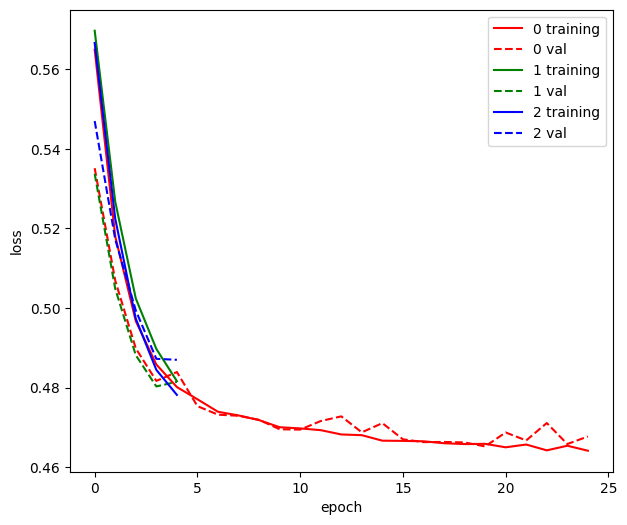

In [205]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
color_list = ['r', 'g', 'b']
for k_fold_idx, (history, color) in enumerate(zip(kfold_history, color_list)):
  ax.plot(history.history['loss'], color=color, label=f'{k_fold_idx} training')
  ax.plot(history.history['val_loss'], color=color, ls='--', label=f'{k_fold_idx} val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()


Calculate the mean and standard deviation of the validation loss.

In [206]:
val_loss_mean = np.mean(kfold_val_eval_loss)
val_loss_std = np.std(kfold_val_eval_loss)
print(f'The val loss of the model is {round(val_loss_mean, 3)} +- {round(val_loss_std, 3)}')

The val loss of the model is 0.515 +- 0.036


### Save the model

Lets save the three models of the cross validation

In [207]:
# Loop over all models
for idx, model in enumerate(kfold_model):
    # Save the model
    model.save(f'./models/chapter6_model_crossval{idx}.keras')

## Chapter 7: Application for Higgs Search

Now we can use the neural network from the last chapter to serch for the Higgs boson as detailed in first chapter.

### Statistical Significance

In our analysis, we assess whether observed deviations in data indicate new physics or merely random fluctuations. We need to determine if the difference between expected and observed events is statistically significant.

We begin by assuming a null hypothesis, $H_0$: The Higgs boson does not exist and the observed phenomena can be explained solely by background events. Next, we calculate the probability of observing a deviation from $H_0$ as significant as or more than our actual measurements using a Poisson distribution, which approximates a Gaussian distribution for large expected values.

For a quick interpretation of these probabilities, we convert them into standard deviations, or the statistical significance $Z$, where $Z_{stat} = \frac{|N_{pred} - N_{meas}|}{\sqrt{N_{pred}}}$.

This statistical approach helps us decide whether to reject the null hypothesis and consider alternative explanations, thus guiding our understanding of potential new physics.

### Higgs Measurement with Neural Networks

Given the low significance when considering all events combined, we now utilize our neural networks to enhance this sensitivity. To improve the significance $Z$, we can either increase the Higgs signal or reduce the background. Since our dataset is fixed and cannot provide more Higgs events, our strategy focuses on reducing background noise. This reduction is achieved through the classifications provided by our neural networks. Each event is scored between 0 and 1 by the network; scores closer to 1 indicate a higher likelihood of the event being a Higgs event. Consequently, we implement a threshold similar to the preselection criteria discussed in chapter 1. Only events with a classification score above this threshold are included in our significance calculation.

<div>
<img src='figures/significance_cut_value.png' width='500'/>
</div>

To avoid a bias resulting from the training we will only use the test data frame not used for any training so far.

In [208]:
# Extract the values, weights, and classification of the test dataset
test_values, test_weights, test_classification = common.get_dnn_input(test_data_frames, training_variables, sample_list_signal, sample_list_background)

For the significance calculation we split the test data into signal and bakcground events.

In [209]:
# Split the data in signal and background
test_signal_values = test_values[test_classification > 0.5]
test_signal_weights = test_weights[test_classification > 0.5]
test_bkg_values = test_values[test_classification < 0.5]
test_bkg_weights = test_weights[test_classification < 0.5]

Now the neural networks can be used to improve the significance.

In [210]:
# Load the models of chapter 2
model_chapter2 = tf.keras.models.load_model('./models/chapter2_model.keras')

As in the chapters before we apply our model but now seperately for signal and background events. In order to simplify the next steps we transform this prediction into one dimensional numpy arrays.

In [211]:
# Model prediction from chapter 2
test_signal_chapter2_prediction = model_chapter2.predict(test_signal_values)
test_bkg_chapter2_prediction = model_chapter2.predict(test_bkg_values)

# Transform predicton to array
test_signal_chapter2_prediction = np.array([element[0] for element in test_signal_chapter2_prediction])
test_bkg_chapter2_prediction = np.array([element[0] for element in test_bkg_chapter2_prediction])

4636/4636 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


Let us vary the cut value to observe which effects are produced

In [212]:
cut_value = 0.0
# Number of signal and background events passing the prediction selection
n_signal = test_signal_weights[test_signal_chapter2_prediction > cut_value].sum()
n_bkg = test_bkg_weights[test_bkg_chapter2_prediction > cut_value].sum()

# Significance
significance = n_signal / np.sqrt(n_bkg)

print(f'The prediction selection is passed by {round(n_signal, 2)} signal and {round(n_bkg, 2)} background events.')
print(f'This results in a significance of {round(significance, 3)}')

The prediction selection is passed by 9.7 signal and 390.61 background events.
This results in a significance of 0.491


To identify the optimal cut-off value and corresponding significance, a function is designed to compute the significance iteratively. This function applies a given model to specific signal and background events and calculates the significance for different cut values. Calculations are conducted within a for loop, which terminates if the count of background events falls below 10. This approach is implemented using the model from Chapter 2.

In [213]:
def get_significances(model, signal_values, bkg_values, signal_weights, bkg_weights):
    # Model prediction
    signal_prediction = model.predict(signal_values)
    bkg_prediction = model.predict(bkg_values)

    # Transform predicton to array
    signal_prediction = np.array([element[0] for element in signal_prediction])
    bkg_prediction = np.array([element[0] for element in bkg_prediction])
    
    # Calculate the significance for different cut values in a for loop
    cut_values = []
    significances = []
    for cut_value in np.linspace(0, 1, 1000):
        # Number of signal and background events passing the prediction selection
        n_signal = signal_weights[signal_prediction > cut_value].sum()
        n_bkg = bkg_weights[bkg_prediction > cut_value].sum()

        # Break if less than 10 background events
        if n_bkg < 10:
            break

        # Significance calculation
        significance = n_signal / np.sqrt(n_bkg)
        
        # Append the cut value and the significances to their lists
        cut_values.append(cut_value)
        significances.append(significance)
    return cut_values, significances

In [214]:
# Calculate the significances by the previous model
model_chapter2_cut_values, model_chapter2_significances = get_significances(model_chapter2, test_signal_values, test_bkg_values, test_signal_weights, test_bkg_weights)
print(model_chapter2_significances[:50])

4636/4636 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
[0.4905630841793665, 0.4909887496047574, 0.49106507628398466, 0.4911768790545843, 0.49125942667348316, 0.4913745988195936, 0.4914992752303629, 0.49160045688694415, 0.4916742759008644, 0.491753453703112, 0.4918472508387195, 0.491899749212873, 0.4919965869710433, 0.49213718589794353, 0.4923597161247273, 0.4926991407472609, 0.4932401551826313, 0.4937574295768979, 0.4945465102234106, 0.4952782750231688, 0.49611885836672787, 0.4969625838615828, 0.498009078486519, 0.4989584092601162, 0.5001677206133797, 0.5013127351834825, 0.5024523563965616, 0.5035418498622655, 0.5047148692068999, 0.5058207562297369, 0.5071535601851938, 0.508439297636483, 0.5096404394008112, 0.510900784660681, 0.5121443805023967, 0.5133685313216289, 0.5145667652157954, 0.5158275604175199, 0.5167347136574222, 0.5179162012377411, 0.51896494415768, 0.5201028033342427, 0.5212046648191163, 0.5224297229980055, 0.5235308815168703, 0.524764236470

Save this function 

In [215]:
%%writefile functions/get_significances.py
import numpy as np

Overwriting functions/get_significances.py


In [216]:
from inspect import getsource, getmodulename
%save -a functions/get_significances.py getsource(get_significances)

The following commands were written to file `functions/get_significances.py`:
def get_significances(model, signal_values, bkg_values, signal_weights, bkg_weights):
    # Model prediction
    signal_prediction = model.predict(signal_values)
    bkg_prediction = model.predict(bkg_values)

    # Transform predicton to array
    signal_prediction = np.array([element[0] for element in signal_prediction])
    bkg_prediction = np.array([element[0] for element in bkg_prediction])
    
    # Calculate the significance for different cut values in a for loop
    cut_values = []
    significances = []
    for cut_value in np.linspace(0, 1, 1000):
        # Number of signal and background events passing the prediction selection
        n_signal = signal_weights[signal_prediction > cut_value].sum()
        n_bkg = bkg_weights[bkg_prediction > cut_value].sum()

        # Break if less than 10 background events
        if n_bkg < 10:
            break

        # Significance calculation
        signif

Plot the significance for different cut values

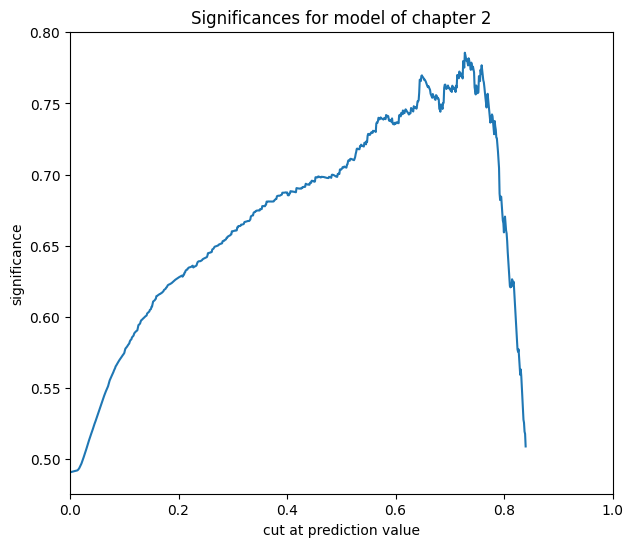

In [217]:
# Plot the significances
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(model_chapter2_cut_values, model_chapter2_significances)
ax.set_title('Significances for model of chapter 2')
ax.set_xlabel('cut at prediction value')
ax.set_ylabel('significance')
ax.set_xlim(0, 1)
_ = plt.show()

Display which is the best significance for the model

In [218]:
print(f'The best significance by the model of chapter 2 is {round(max(model_chapter2_significances), 3)}')

The best significance by the model of chapter 2 is 0.786


### Comparison between models


Load the neural networks created in chapter 4 and chapter 5 and calculate their significances for different cut values. Compare the significances for all of the three models in one plot. 

In [219]:
# Load the models of chapter 4 and chapter 5
model_chapter4 = tf.keras.models.load_model('./models/chapter4_model.keras')
model_chapter5 = tf.keras.models.load_model('./models/chapter5_model.keras')

In [220]:
# Calculate the significances by the model of chapter 4 and chapter 5
model_chapter4_cut_values, model_chapter4_significances = get_significances(model_chapter4, test_signal_values, test_bkg_values, test_signal_weights, test_bkg_weights)
model_chapter5_cut_values, model_chapter5_significances = get_significances(model_chapter5, test_signal_values, test_bkg_values, test_signal_weights, test_bkg_weights)

4636/4636 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
4636/4636 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
6541/6541 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


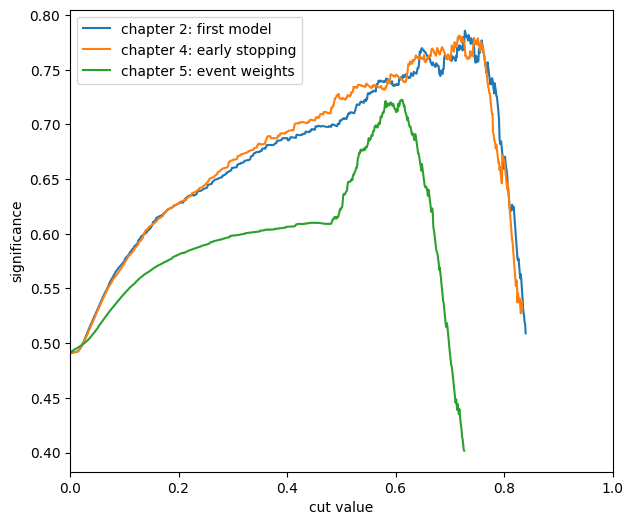

In [221]:
# Plot the significances
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(model_chapter2_cut_values, model_chapter2_significances, label='chapter 2: first model')
ax.plot(model_chapter4_cut_values, model_chapter4_significances, label='chapter 4: early stopping')
ax.plot(model_chapter5_cut_values, model_chapter5_significances, label='chapter 5: event weights')
ax.set_xlabel('cut value')
ax.set_ylabel('significance')
ax.set_xlim(0, 1)
ax.legend()
_ = plt.show()

In [222]:
print(f'The best significance by the model of chapter 2 is {round(max(model_chapter2_significances), 3)}')
print(f'The best significance by the model of chapter 4 is {round(max(model_chapter4_significances), 3)}')
print(f'The best significance by the model of chapter 5 is {round(max(model_chapter5_significances), 3)}')

The best significance by the model of chapter 2 is 0.786
The best significance by the model of chapter 4 is 0.781
The best significance by the model of chapter 5 is 0.722
